<a href="https://colab.research.google.com/github/emsmullen/VirtueSemantics/blob/main/VirtueSemantics_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up

In [35]:
#import packages
import sys, os, random, requests, json #connects with interpreter; interacts with os; HTTP requests; JSON data
import pandas as pd #data structures and analysis tools
import numpy as np #for multi-dimensional data and mathematical functions (arrays)
import scipy.stats as st #complex computations (numerical)
import matplotlib.pyplot as plt #for plotting data
from google.colab import drive, data_table, userdata #access Google Drive; interactive pandas dataframes; secrets
import sklearn

In [36]:
#set up paths for local modules and data sources
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/MyDrive/')
stim_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [37]:
#set environment variable with API key and github token
%env OPENAI_API_KEY = userdata.get('OAI') #APIs connect software applications
%env github_token = userdata.get('git')

env: OPENAI_API_KEY=userdata.get('OAI') #APIs connect software applications
env: github_token=userdata.get('git')


In [38]:
#read in stimuli stored on google drive (must add this file to drive)
#action list
action_data = pd.read_csv(stim_path+"ValueSemantics/action_neurips.csv")
action_list_all = action_data["actions"].tolist()
n_items = len(action_list_all)

#virtues - sourced from JAK Tomson on the Aristotelean virtues - https://philosophy.tamucc.edu/notes/aristotelian-virtues
virtue_data = pd.read_csv(stim_path+"ValueSemantics/excess_deficiency_mean.csv")
virtue_list_all = virtue_data["excess"].tolist() + virtue_data["deficiency"].tolist() + virtue_data["mean"].tolist()
n_virtues = len(virtue_list_all)

#sorting virtues by excess, mean, deficiency
excess_list = virtue_data["excess"].tolist()
deficiency_list = virtue_data["deficiency"].tolist()
mean_list = virtue_data["mean"].tolist()

# Embedding Projections

In [39]:
#@title define functions
def getEmbeddings(text):
    url = 'https://api.openai.com/v1/embeddings'
    headers = {
      "Content-Type": "application/json",
      "Authorization": userdata.get('OAI')
      }
    data = {
        "input": text,
        "model": "text-embedding-ada-002"
    }
    response = requests.post(url, headers=headers, json=data)

    return response.json()

#function to get the difference of embeddings of two texts
def return_embeddings_diff(attributes_a, attributes_b):
  '''
  Pass two sets of attributes and get all vector differences of all a-b combinations
  NOTE: The distinction between high and low embeddings is automatically made by given data
  '''
  emb_high = pd.DataFrame()
  emb_low = pd.DataFrame()

  #loop through each attribute set and save the embeddings in two dataframes
  for a in range(len(attributes_a)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_a[a])
    emb_high.insert(loc=0, column=a, value=this_emb["data"][0]["embedding"])

  for b in range(len(attributes_b)):
    #get embedding of the high, low, and compute difference
    this_emb = getEmbeddings(attributes_b[b])
    emb_low.insert(loc=0, column=b, value=this_emb["data"][0]["embedding"])

  #get all differences
  vector_diff = pd.DataFrame()

  #report correlations
  print(emb_low.corr()) #correlations are higher when closer to 1
  print(emb_high.corr())

  for a in range(len(attributes_a)):
    for b in range(len(attributes_b)):
      this_col = str(a)+'_'+str(b)
      vector_diff.insert(loc=0, column=this_col, value=emb_high[a] - emb_low[b])

  return(vector_diff.mean(axis=1)) #pandas series; contains average value per row for overall differences in embeddings


def return_list_embeddings(alist):
  '''
  get embeddings for a list of items
  '''
  n_df = pd.DataFrame()
  for i in alist:
    this_em = getEmbeddings(i)["data"][0]["embedding"]
    n_df.insert(loc=0, column=i, value=this_em, allow_duplicates=True)

  return (n_df)


def get_projections(stim_list, moral_v, hedonic_v, movement_v):
  '''
  get projections for list of items
  '''
  #construct dataframe to save items
  projection_df = pd.DataFrame(index=stim_list, columns=['moral_v','hedonic_v','movement_v'], data=0)

  #loop through items to get embeddings in moral, hedonic, and movement vector directions

  for a in stim_list:
    this_em = getEmbeddings(a)["data"][0]["embedding"]
    projection_moral = np.inner(np.array(this_em),np.array(moral_v))
    projection_hedonic = np.inner(np.array(this_em),np.array(hedonic_v))
    projection_movement = np.inner(np.array(this_em),np.array(movement_v))
    projection_df.loc[a, "moral_v"] = projection_moral
    projection_df.loc[a, "hedonic_v"] = projection_hedonic
    projection_df.loc[a, "movement_v"] = projection_movement

  return projection_df

In [40]:
virtue_embeddings = return_list_embeddings(virtue_list_all)

In [ ]:
virtue_embeddings

,righteous indignation,modesty,friendliness,wittiness,truthfulness,patience,pride,magnanimity,magnificence,liberality,...,obsequiousness,buffoonery,boastfulness,irascibility,empty vanity,vanity,vulgarity,prodigality,licentiousness,rashness
0,-0.011200,-0.002438,0.004982,-0.008253,-0.010826,-0.004497,0.000002,-0.004681,-0.008041,-0.005600,...,-0.029072,-0.039844,-0.019953,-0.018716,-0.007868,-0.004206,-0.004958,0.000680,0.005233,0.020570
1,-0.016460,-0.011328,-0.001430,-0.008199,-0.012531,0.000947,-0.023082,-0.017111,0.007849,-0.014227,...,-0.005782,-0.013117,0.005599,-0.008635,-0.005754,-0.010891,-0.008772,-0.041449,0.008762,0.009405
2,-0.005365,0.004673,0.005881,0.001512,-0.005146,0.003699,0.008849,0.019226,0.018468,-0.003365,...,0.005070,0.026140,0.019859,0.013484,0.013062,0.027552,0.016558,-0.002456,0.014844,0.013400
3,-0.025483,-0.017756,-0.025036,-0.007872,-0.020114,-0.029675,-0.031573,-0.030045,-0.037228,-0.040953,...,-0.020626,-0.008166,-0.027910,-0.035235,0.017285,-0.021650,-0.004324,-0.032974,-0.043192,-0.030156
4,-0.012689,-0.022807,0.007567,-0.004410,-0.005239,0.006433,0.006235,-0.004956,0.005353,-0.018043,...,0.001490,-0.012750,-0.002643,-0.011455,-0.040163,-0.022623,-0.019148,-0.020084,-0.002985,-0.004924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.056259,0.045173,0.037464,0.057476,0.015701,0.019862,0.045696,0.086665,0.056267,0.041091,...,0.048322,0.056683,0.059791,0.024410,0.032858,0.026395,0.026879,0.056138,0.047603,0.042240
1532,-0.004270,-0.008217,0.015217,0.004771,-0.000435,0.015879,0.007445,-0.001819,-0.000325,0.000922,...,-0.002687,-0.004420,-0.011902,0.031859,-0.024739,-0.004745,-0.000353,0.002228,0.015696,0.018865
1533,-0.009368,-0.005640,-0.027110,-0.019537,-0.001844,-0.008738,-0.028843,-0.031862,-0.024567,-0.025233,...,-0.012908,-0.001076,-0.026447,-0.014804,-0.013822,-0.013099,-0.030511,-0.017536,-0.019959,-0.030774
1534,0.010565,0.002448,-0.001856,0.004580,0.016369,0.016789,0.020715,0.002339,-0.003384,0.018306,...,0.011240,0.013037,0.019094,0.012754,0.010231,0.008157,0.014200,0.025616,0.030391,0.020623


## generate embeddings

In [41]:
#virtues_PCA = sklearn.decomposition.PCA(virtue_embeddings,n_components=3)
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(virtue_embeddings)
pca.fit_transform(virtue_embeddings)

array([[-0.05169   ,  0.00632754,  0.00254347],
       [-0.05160331,  0.01000017, -0.01246741],
       [ 0.0671584 ,  0.00703528, -0.02064189],
       ...,
       [-0.09017092,  0.00434648,  0.01764758],
       [ 0.05631607, -0.00078352, -0.02217492],
       [-0.15907393,  0.00265171,  0.00464157]])

In [42]:
#cosine similarity of virtues -


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Sample data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([[7, 8, 9], [10, 11, 12]])

# Compute cosine similarity
similarity_matrix = cosine_similarity(X, Y)


[[0.95941195 0.95125831]
 [0.99819089 0.99614986]]


In [43]:
# rankings
# moral, virtuous, ethical, good, right, proper, etc.

In [44]:
# get moral direction in GPT embeddings
attributes_morality_high = ['morally virtuous','ethical', 'high moral value']
attributes_morality_low = ['morally wrong','unethical', 'low moral value']
moral_v = return_embeddings_diff(attributes_morality_high, attributes_morality_low)

# get hedonic direction in GPT embeddings
attributes_hedonic_high = ['personally rewarding','pleasurable for me', 'high hedonic value for me']
attributes_hedonic_low = ['personally costly','unpleasurable for me', 'low hedonic value for me']
hedonic_v = return_embeddings_diff(attributes_hedonic_high, attributes_hedonic_low)

# get physicality direction in GPT embeddings
attributes_movement_high = ['physical','bodily action', 'high movement']
attributes_movement_low = ['mental','minimally active', 'low movement']
movement_v = return_embeddings_diff(attributes_movement_high, attributes_movement_low)


          2         1         0
2  1.000000  0.849759  0.875315
1  0.849759  1.000000  0.893319
0  0.875315  0.893319  1.000000
          2         1         0
2  1.000000  0.833950  0.891547
1  0.833950  1.000000  0.831318
0  0.891547  0.831318  1.000000
          2         1         0
2  1.000000  0.856273  0.806584
1  0.856273  1.000000  0.804478
0  0.806584  0.804478  1.000000
          2         1         0
2  1.000000  0.881714  0.822901
1  0.881714  1.000000  0.844764
0  0.822901  0.844764  1.000000
          2         1         0
2  1.000000  0.849063  0.759322
1  0.849063  1.000000  0.760345
0  0.759322  0.760345  1.000000
          2         1         0
2  1.000000  0.795824  0.783809
1  0.795824  1.000000  0.842920
0  0.783809  0.842920  1.000000


In [45]:
# Report correlation among attribute embeddings
print('Embedding Correlations:')
print('r(moral, hedonic) = '+ str(round(np.corrcoef(moral_v, hedonic_v)[0, 1], 2)))
print('r(moral, movement) = '+ str(round(np.corrcoef(moral_v, movement_v)[0, 1], 2)))
print('r(hedonic, movement) = '+ str(round(np.corrcoef(hedonic_v, movement_v)[0, 1], 2)))


Embedding Correlations:
r(moral, hedonic) = 0.44
r(moral, movement) = 0.1
r(hedonic, movement) = 0.16


## generate projections on embeddings

In [46]:
# get projections of stimuli onto each vector direction
#item_projections = get_projections(action_list_all, moral_v, hedonic_v, movement_v, social_v)
excess_projections = get_projections(excess_list, moral_v, hedonic_v, movement_v)
deficiency_projections = get_projections(deficiency_list, moral_v, hedonic_v, movement_v)
mean_projections = get_projections(mean_list, moral_v, hedonic_v, movement_v)


<ipython-input-39-9a4e52498519>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008071131498719054' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "moral_v"] = projection_moral
<ipython-input-39-9a4e52498519>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.009122484070860545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "hedonic_v"] = projection_hedonic
<ipython-input-39-9a4e52498519>:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.022448769080350497' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "movement_v"] = projection_movement
<ipytho

NameError: name 'item_projections' is not defined

In [47]:
excess_projections

,moral_v,hedonic_v,movement_v
rashness,-0.008071,-0.009122,0.022449
licentiousness,-0.013034,0.006961,0.015980
prodigality,0.002201,0.017647,0.020526
vulgarity,-0.020726,-0.014294,0.027819
vanity,0.014417,0.005062,0.013461
empty vanity,0.011998,-0.003565,0.002750
irascibility,0.007379,-0.001572,0.008374
boastfulness,0.028942,0.030158,0.030364
buffoonery,-0.024349,-0.001301,0.019115
obsequiousness,0.017264,0.018499,0.009851


In [48]:
data = {'excess': virtue_data['excess'],
        'excess value': excess_projections['moral_v'].tolist(),
        'mean': virtue_data['mean'],
        'mean value': mean_projections['moral_v'].tolist(),
        'deficiency': virtue_data['deficiency'],
        'deficiency value': deficiency_projections['moral_v'].tolist()
}


In [49]:
df = pd.DataFrame(data)
df

,excess,excess value,mean,mean value,deficiency,deficiency value
0,rashness,-0.008071,courage,0.033242,cowardice,-0.015971
1,licentiousness,-0.013034,temperance,0.030927,insensibility,-0.020224
2,prodigality,0.002201,liberality,0.028638,meanness,-0.017885
3,vulgarity,-0.020726,magnificence,0.037886,pettiness,-0.018403
4,vanity,0.014417,magnanimity,0.039111,pusillanimity,0.013156
5,empty vanity,0.011998,pride,0.033119,unambitiousness,-0.008152
6,irascibility,0.007379,patience,0.026655,lack of spirit,-0.015379
7,boastfulness,0.028942,truthfulness,0.033198,mock modesty,0.013505
8,buffoonery,-0.024349,wittiness,0.020617,boorishness,-0.012459
9,obsequiousness,0.017264,friendliness,0.032362,cantankerousness,0.008686


In [55]:
item_projections = get_projections(action_list_all, moral_v, hedonic_v, movement_v)
item_projections["item"] = item_projections.index

<ipython-input-39-9a4e52498519>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.017291674112935654' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "moral_v"] = projection_moral
<ipython-input-39-9a4e52498519>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.017777573601155377' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "hedonic_v"] = projection_hedonic
<ipython-input-39-9a4e52498519>:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01419051490411137' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  projection_df.loc[a, "movement_v"] = projection_movement


<ipython-input-56-36cdd83c0fbc>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))


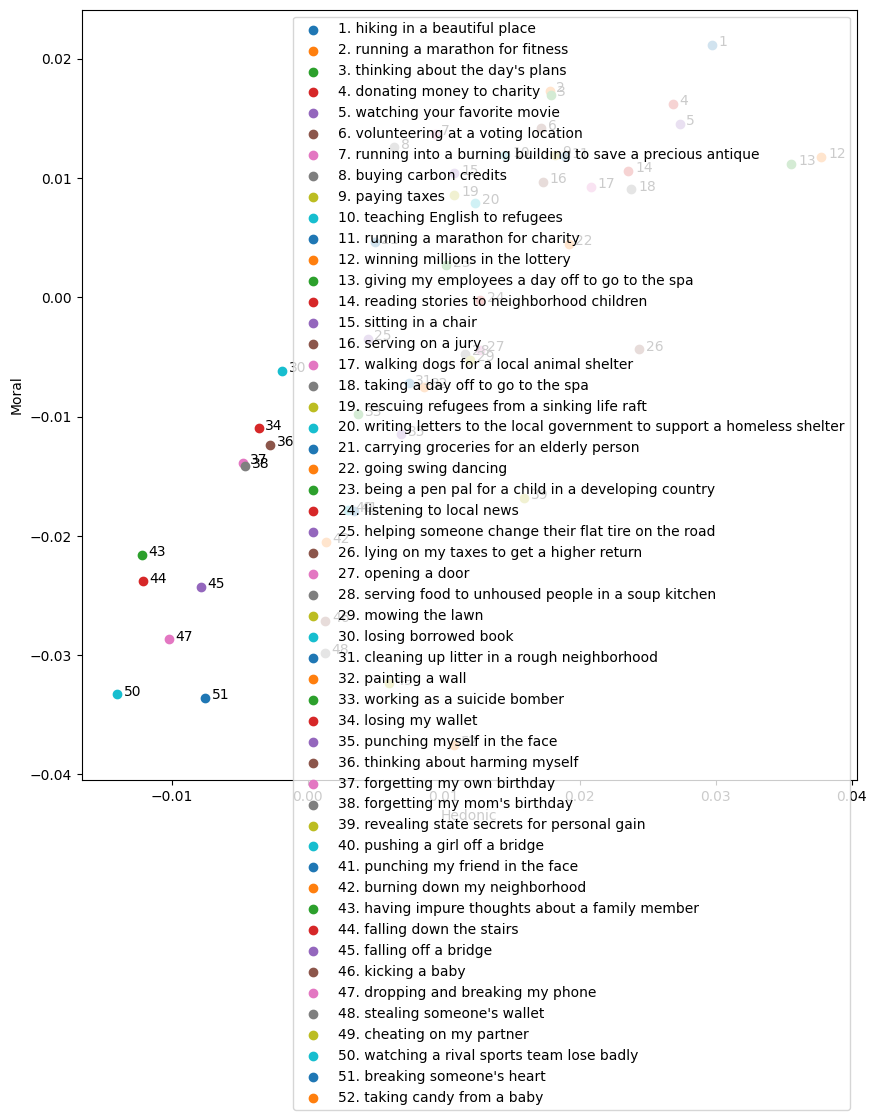

In [56]:
# Plot Embeddings for Moral x Hedonic

# sort projections by morality before plotting
item_projections_1 = item_projections.sort_values('moral_v', ascending=False)


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap("tab20")

plot_i = 1
for i in range(len(item_projections_1)):
    x = item_projections_1['hedonic_v'].iloc[i]
    y = item_projections_1['moral_v'].iloc[i]
    colors = cmap(i/len(item_projections_1))
    l = str(plot_i) + '. ' + item_projections_1.index[i].lstrip('[').rstrip(']')
    ax.scatter([x],[y], label=l)
    ax.annotate(plot_i, (item_projections_1['hedonic_v'][i]+.0005, item_projections_1['moral_v'][i]-.0001))
    plot_i += 1

ax.set_xlabel('Hedonic')
ax.set_ylabel('Moral')
ax.legend()

In [52]:
# @title define functions


def promptGPT(prompt_message_list, gpt_temperature=0):
  gpt_url = "https://api.openai.com/v1/chat/completions"
  gpt_headers = {
    "Content-Type": "application/json",
    "Authorization": userdata.get('OAI')
    }
  gpt_data = {
        "model": "gpt-3.5-turbo-1106",
        "response_format": {"type": "json_object"}, # only works on 3.5-turbo-1106, 4 and above
        "temperature": gpt_temperature,
        "messages": prompt_message_list,
    }
  response = requests.post(gpt_url, headers=gpt_headers, json=gpt_data)
  output = response.json()['choices'][0]['message']['content']

  return output

def prompt_sort(action_list, dimension, context=""):
  """
  Given a list of actions to sort, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the ranking results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #randomize the order of the list
  random.shuffle(action_list)

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative moral virtue according to Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the most morally wrong, and ending with the most morally virtuous from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["walk a dog", "rob a bank", "rescue a cat", "steal food"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["rob a bank", "steal food", "walk a dog", "rescue a cat"]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward of different actions.
Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of their relative hedonic reward for Ziv.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array<string>: A sorted list of actions, starting with the
worst and least hedonically rewarding, and ending with the best and most hedonically rewarding from Ziv's perpsective."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["miss the bus", "win a sweepstakes", "eat a meal", "lose my wallet"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement
of different actions. Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
You must sort them in terms of how much physical movement they involve.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: an unsorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:

1. ranking - Array<string>: A sorted list of actions, starting with the
least physical body movement, and ending with the most physical body movement."""
    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["play soccer", "listen to music", "pack boxes", "order coffee at a cafe"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]


def prompt_rate_sorted(action_list, dimension, context=""):
  """
  Given a sorted list of actions to rate, and a dimension to sort them on, craft a prompt
  for GPT, with example calls and responses.

  Optionally, include context regarding the hypothetical rater (Ziv),
  which may influence the rating results.

  Returns a list of dicts to pass on to GPT as prompt messages
  """

  #turn list into formatted string
  action_string = (', ').join(action_list)

  # Switch by sorting dimension
  if dimension == 'moral':

    system_prompt_content = """You are an expert judge of the relative moral virtues of different actions.
Moral actions are those which humans consider virtuous, that consider others' wellbeing and happiness, and that are guided by principles of ethics.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative moral virtue according to Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar in terms of moral virtue, and 10 if the actions are very different in terms of moral virtue.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["rob a bank", "steal food", "walk a dog", "rescue a cat"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["rob a bank", 0], ["steal food", 3], ["walk a dog", 10], ["rescue a cat", 6]]})
    }

  elif dimension == 'hedonic':

    system_prompt_content = """You are an expert judge of the relative hedonic reward
of different actions. Hedonically rewarding actions are those which humans consider pleasant, make them feel happy, and benefit their own wellbeing.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of their relative hedonic reward for Ziv.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of hedonic reward, and 10 if the actions are very different in terms of hedonic reward.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["lose my wallet", "miss the bus", "eat a meal", "win a sweepstakes"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["lose my wallet", 0], ["miss the bus", 2], ["eat a meal", 9], ["win a sweepstakes", 8]]})
    }

  elif dimension == 'movement':

    system_prompt_content = """You are an expert judge of the physical body movement of different actions.
Physically active actions are those which humans consider to involve substantial movement of the body.
You will be given a list of actions that an average human person, Ziv, is considering.
They are already sorted in terms of how much physical movement they involve.
You will assign a number to each adjacent pair, rating 0 if the actions are very similar
in terms of amount of physical movement, and 10 if the actions are very different in terms of amount of physical movement.
You will give the first action a rating of 0. You will give the second action a rating in comparison to the first action, and so on.
You will recieve a JSON object of items to rate. This object will have the following key / value pairs:
1. actions - Array<string>: a sorted list of actions that the user has been faced with
2. context - string: information that you can use to help you make your choice
You must respond with a JSON packet with a single key / value pair:
1. ranking - Array: A list of lists, each list contains 2 elements:
1. action from the original list
2. similarity rating from 0 to 10 between this action and the previous action in the list"""

    system_prompt= {
        "role": "system",
        "content": system_prompt_content
    }
    user_example = {
        "role": "user",
        "content": json.dumps({"actions": ["listen to music", "order coffee at a cafe", "pack boxes", "play soccer"],
                               "context": ""}) # Initial example has no context
    }
    assistant_example = {
        "role": "assistant",
        "content": json.dumps({"ranking": [["listen to music", 0], ["order coffee at a cafe", 2], ["pack boxes", 6], ["play soccer", 9]]})
    }

  else:
    raise Exception("Specify a rating dimension: moral, hedonic, movement")


  # List actions to sort
  user_prompt = {
      "role": "user",
      "content": json.dumps({"actions": action_list,
                             "context": context}) # Optional context, defaults to empty string
  }

  return [system_prompt, user_example, assistant_example, user_prompt]

def sort_rate(action_list, dimension):

  # Sort actions
  resp = promptGPT(prompt_sort(action_list, dimension))
  resp_sorted_list = json.loads(resp)['ranking']

  # Rate distance between sorted actions
  resp = promptGPT(prompt_rate_sorted(resp_sorted_list, dimension))
  resp_rated_list = json.loads(resp)['ranking']

  # parse the ratings into a dataframe
  resp_df = pd.DataFrame(resp_rated_list, columns=['item', 'rating'])
  resp_df['rating'] = pd.to_numeric(resp_df['rating'])
  resp_df['rating_sum'] = resp_df['rating'].cumsum()
  resp_df['rescored_' + dimension] = resp_df['rating_sum'] / resp_df['rating_sum'].max() * 100
  resp_df = resp_df.drop(columns=['rating', 'rating_sum'])

  return resp_df